In [1]:
import numpy as np
import pandas as pd
import os
import yaml
import matplotlib.pyplot as plt
import torch

from utils import *
from train import Net

pd.set_option('display.max_columns', 15)  # Adjust the number as needed
pd.set_option('display.expand_frame_repr', False)  # Disable automatic wrapping


In [2]:
# exp_id = ["122", "123", "124", "125", "126", "127", "128"]
exp_id = '143'
exp_dir = create_exp_folder(exp_id)
print("Experiment folder: ", exp_dir)

Experiment ID: 143
Experiment folder:  experiments/143


In [5]:
# get the list of runs within the experiment folder
runs = os.listdir(exp_dir)
runs = [run for run in runs if os.path.isdir(os.path.join(exp_dir, run))] # filter out files

# if this is run over some unfinished experiment, cut off the last run since it doesnt have saved data yet
runs = runs[:-1]

[print(run) for run in runs]; #! remove


lr_0_01_hdim_64_lay_1_rate_0_0_sched_CAWR
lr_0_01_hdim_16_lay_2_rate_0_0_sched_CAWR
lr_0_01_hdim_32_lay_4_rate_0_4_sched_Cycl
lr_0_01_hdim_32_lay_1_rate_0_2_sched_Cycl
lr_0_01_hdim_16_lay_2_rate_0_4_sched_CAWR
lr_0_01_hdim_64_lay_1_rate_0_0_sched_Cycl
lr_0_01_hdim_32_lay_1_rate_0_0_sched_CAWR
lr_0_01_hdim_16_lay_4_rate_0_0_sched_CAWR
lr_0_01_hdim_32_lay_2_rate_0_4_sched_CAWR
lr_0_01_hdim_16_lay_4_rate_0_2_sched_Cycl
lr_0_01_hdim_16_lay_4_rate_0_2_sched_CAWR
lr_0_01_hdim_16_lay_4_rate_0_0_sched_Cycl
lr_0_01_hdim_64_lay_1_rate_0_2_sched_Cycl
lr_0_01_hdim_16_lay_2_rate_0_4_sched_Cycl
lr_0_01_hdim_32_lay_4_rate_0_0_sched_CAWR
lr_0_01_hdim_32_lay_4_rate_0_2_sched_CAWR
lr_0_01_hdim_32_lay_1_rate_0_2_sched_CAWR
lr_0_01_hdim_16_lay_2_rate_0_2_sched_CAWR
lr_0_01_hdim_32_lay_2_rate_0_0_sched_Cycl
lr_0_01_hdim_32_lay_1_rate_0_0_sched_Cycl
lr_0_01_hdim_32_lay_4_rate_0_2_sched_Cycl
lr_0_01_hdim_16_lay_4_rate_0_4_sched_CAWR
lr_0_01_hdim_32_lay_2_rate_0_2_sched_Cycl
lr_0_01_hdim_16_lay_4_rate_0_4_sch

In [6]:
# each run path has a config.yaml file and a logs/training_log.csv file
# for the first 10 runs, load the config.yaml file and the training log csv
def extract_min_losses_and_hparams(exp_dir):
    losses_and_hparams = []
    for run in runs:
        path = os.path.join(exp_dir, run)
        config_path = os.path.join(path, "run_config.yml")
        log_path = os.path.join(path, "logs", "training_log.csv")
        
        with open(config_path, 'r') as stream:
            config = yaml.safe_load(stream)

        log = pd.read_csv(log_path)
        log = log[log["Total Loss"] > 0.0] # filter out 0.0-losses from non-reached epochs
        min_loss = log["Total Loss"].min()

        # the config is two layered. Extract the second layer and create a flat dictionary
        hparams = {}
        for category in config:
            c = config[category]
            for key in c:
                hparams[key] = c[key]
        losses_and_hparams.append((min_loss, hparams))
    return losses_and_hparams

losses_and_hparams = extract_min_losses_and_hparams(exp_dir)

In [7]:
# get relevant hyperparamters from a config dictionary
relevant_hparams = ['learning_rate', 'hidden_dim', 'n_layers', 'dropout_rate', 'scheduler', 'adaptive', 'batch_size']
def get_relevant_hparams(config, relevant_hparams):
    return {key: config[key] for key in config if key in relevant_hparams}
# tuned_hparams = get_relevant_hparams(min_run, relevant_hparams)

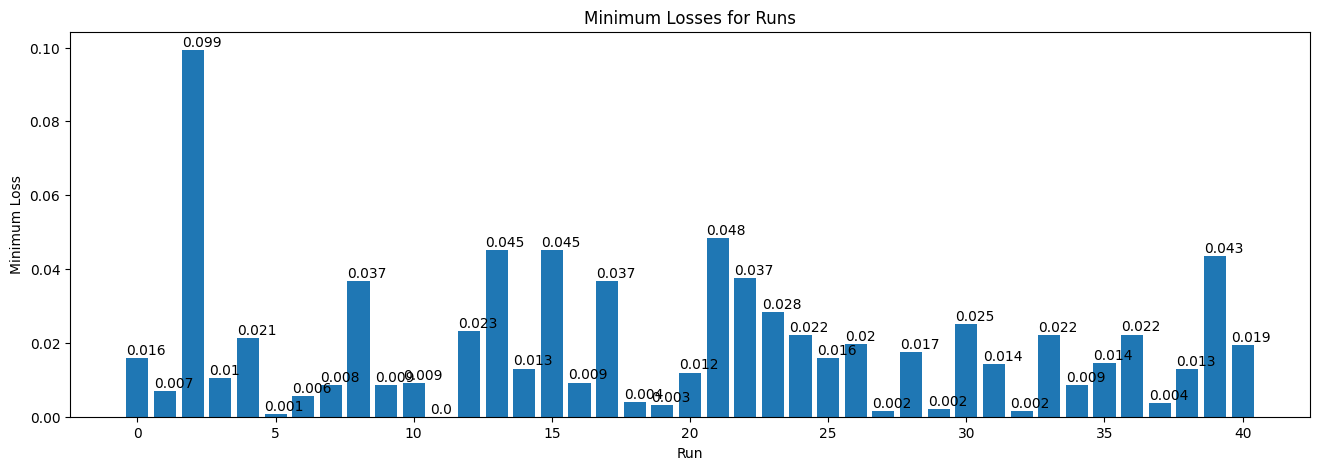

In [8]:
min_l = [loss for loss, _ in losses_and_hparams]
plt.figure(figsize=(16,5), dpi=100)
plt.bar(range(len(min_l)), min_l)
plt.xlabel("Run")
plt.ylabel("Minimum Loss")
plt.title("Minimum Losses for Runs")
# insert the minimum loss values as text above the bars
for i, v in enumerate(min_l):
    plt.text(i - 0.4, v + 0.001, str(round(v, 3)))

plt.show()

In [9]:
# find the run with the lowest loss
min_index = np.argmin(min_l)
# min_run = runs[min_index]
min_run = losses_and_hparams[min_index][1]
print(f"Run {min_index} with lowest loss: {min_run}")

Run 11 with lowest loss: {'batch_size': 16, 'num_collocation_points': 1000, 't_domain': [0, 2], 'x_domain': [-1, 1], 'n_logs': 100, 'tensorboard': False, 'amplitude': 1.0, 'sigma': 0.2, 'wave_speed': 1.0, 'x0': 0.2, 'L2_penalty': 0.005, 'adaptive': True, 'dropout_rate': 0.0, 'epochs': 3000, 'hidden_dim': 16, 'initialization': True, 'learning_rate': 0.01, 'n_layers': 4, 'optimizer': 'AdamW', 'patience': 500, 'scheduler': 'Cycl'}


In [10]:
# find the runs with the 10 lowest losses, their index and their config
min_indices = np.argsort(min_l)[:10]
min_losses = [min_l[i] for i in min_indices]
min_runs = [runs[i] for i in min_indices]
min_configs = [os.path.join(exp_dir, run, "run_config.yml") for run in min_runs]

In [11]:
losses_and_hparams

[(0.0159960098729009,
  {'batch_size': 32,
   'num_collocation_points': 1000,
   't_domain': [0, 2],
   'x_domain': [-1, 1],
   'n_logs': 100,
   'tensorboard': False,
   'amplitude': 1.0,
   'sigma': 0.2,
   'wave_speed': 1.0,
   'x0': 0.2,
   'L2_penalty': 0.005,
   'adaptive': True,
   'dropout_rate': 0.0,
   'epochs': 3000,
   'hidden_dim': 64,
   'initialization': True,
   'learning_rate': 0.01,
   'n_layers': 1,
   'optimizer': 'AdamW',
   'patience': 500,
   'scheduler': 'CAWR'}),
 (0.0068901521573866,
  {'batch_size': 16,
   'num_collocation_points': 1000,
   't_domain': [0, 2],
   'x_domain': [-1, 1],
   'n_logs': 100,
   'tensorboard': False,
   'amplitude': 1.0,
   'sigma': 0.2,
   'wave_speed': 1.0,
   'x0': 0.2,
   'L2_penalty': 0.005,
   'adaptive': True,
   'dropout_rate': 0.0,
   'epochs': 3000,
   'hidden_dim': 16,
   'initialization': True,
   'learning_rate': 0.01,
   'n_layers': 2,
   'optimizer': 'AdamW',
   'patience': 500,
   'scheduler': 'CAWR'}),
 (0.0993180673

In [12]:
min_losses

[9.34824267086894e-06,
 0.0006436135287275,
 0.0015244820149979,
 0.0016390245082915,
 0.0020840412852327,
 0.0031686081557712,
 0.0037550713848966,
 0.0040886755861721,
 0.0057000049698406,
 0.0068901521573866]

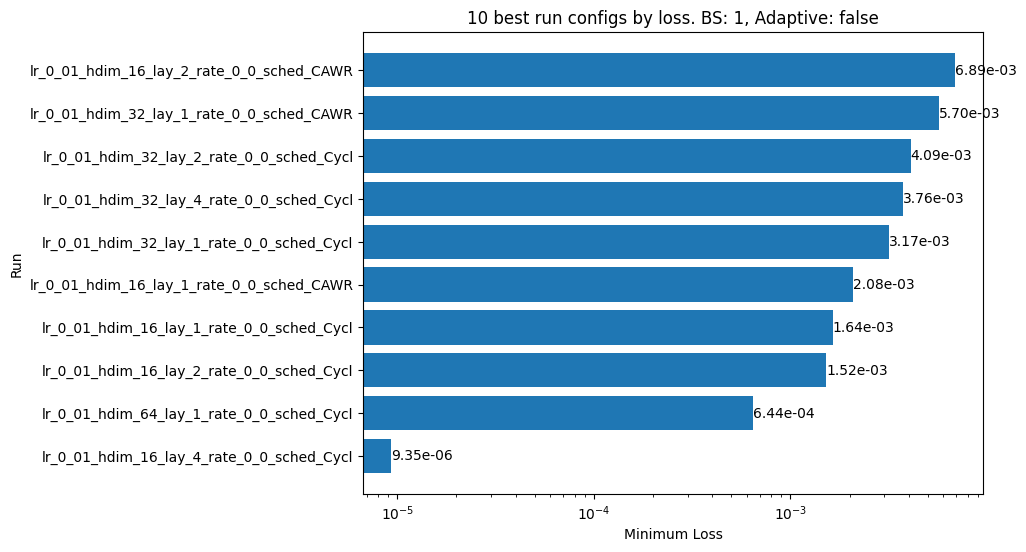

In [13]:
# horizontal bar chart of the 10 runs with the lowest losses
plt.figure(figsize=(8,6), dpi=100)
plt.barh(range(len(min_losses)), min_losses)
plt.xlabel("Minimum Loss")
plt.xscale("log")
plt.ylabel("Run")
# insert the minimum loss values as text next to the bars
for i, v in enumerate(min_losses):
    plt.text(v, i - 0.1, f"{v:.2e}")
# plt.xlim(0, max(min_losses) * 1.1)
# insert name of the run as y-tick labels
plt.yticks(range(len(min_runs)), min_runs)


plt.title(f"10 best run configs by loss. BS: {1}, Adaptive: false")
plt.show()

In [14]:
# we need to know the effect that each hyperparameter value has on the average loss over all runs
def aggregate_hparam_effect(losses_and_hparams):
    hparam_effects = {}  # Dictionary to store the average loss for each hyperparameter value

    for loss, hparams in losses_and_hparams:
        for hparam, value in hparams.items():
            if hparam not in hparam_effects:
                hparam_effects[hparam] = {}
            try:
                if value not in hparam_effects[hparam]:
                    hparam_effects[hparam][value] = []
            except:
                print(hparam, value)


            hparam_effects[hparam][value].append(loss)

    # Calculating average losses
    for hparam in hparam_effects:
        for value in hparam_effects[hparam]:
            hparam_effects[hparam][value] = np.mean(hparam_effects[hparam][value])

    return hparam_effects

losses_and_tuned_hparams = []
for loss, hparams in losses_and_hparams:
    losses_and_tuned_hparams += [(loss, get_relevant_hparams(hparams, relevant_hparams))]

hparam_effects = aggregate_hparam_effect(losses_and_tuned_hparams)


In [15]:
hparam_effects

{'batch_size': {32: 0.020828259388262955, 16: 0.018064468989940404},
 'adaptive': {True: 0.019412659428146524},
 'dropout_rate': {0.0: 0.005799743600394126,
  0.4: 0.03298603466193292,
  0.2: 0.01945524160626376},
 'hidden_dim': {64: 0.015612426775645748,
  16: 0.01846544140724225,
  32: 0.02175685473939839},
 'learning_rate': {0.01: 0.019412659428146524},
 'n_layers': {1: 0.015179738501947189,
  2: 0.020652565500863144,
  4: 0.02462546025078863},
 'scheduler': {'CAWR': 0.019153576334242202, 'Cycl': 0.019659405231864928}}

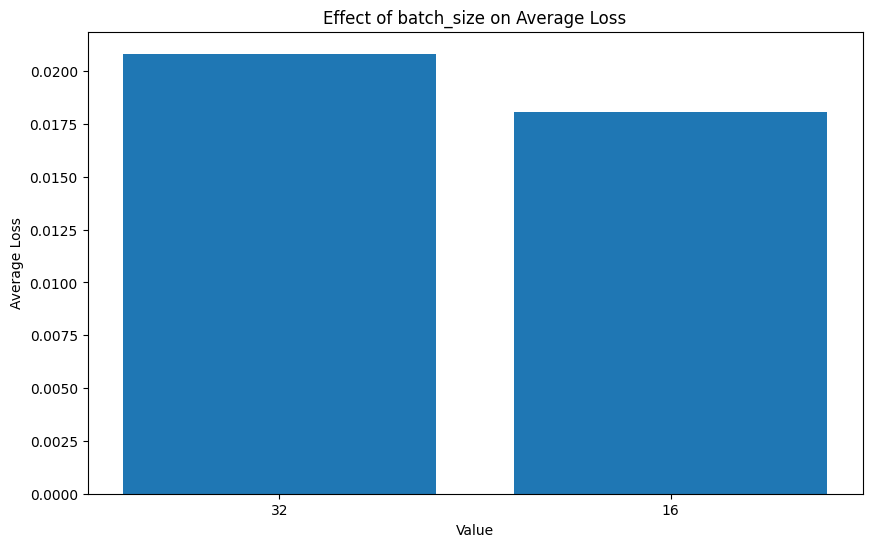

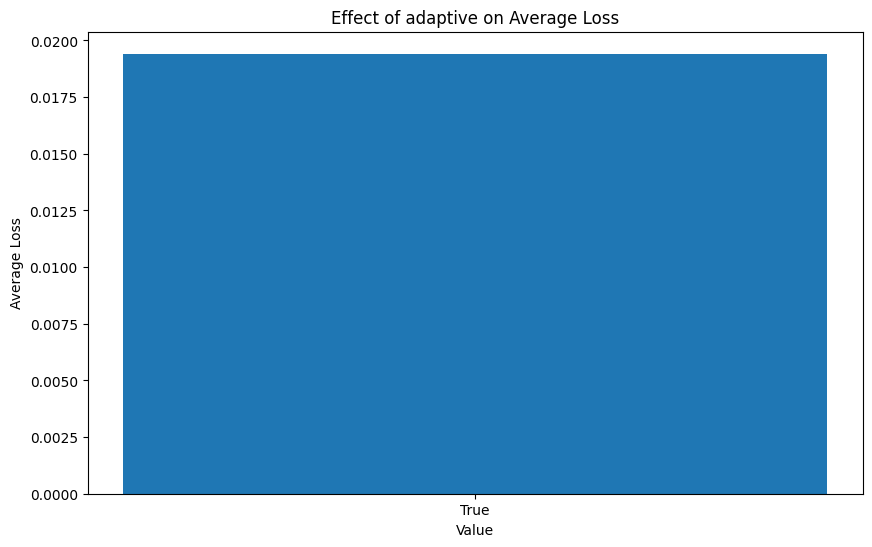

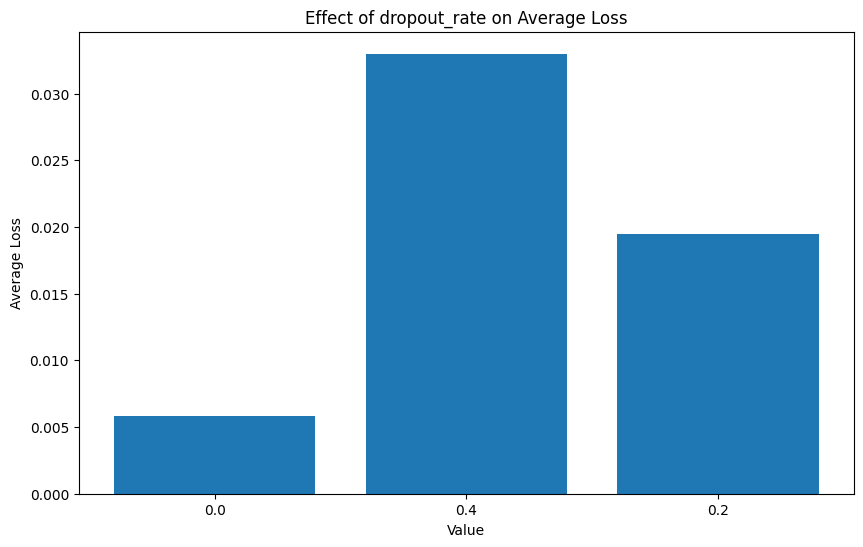

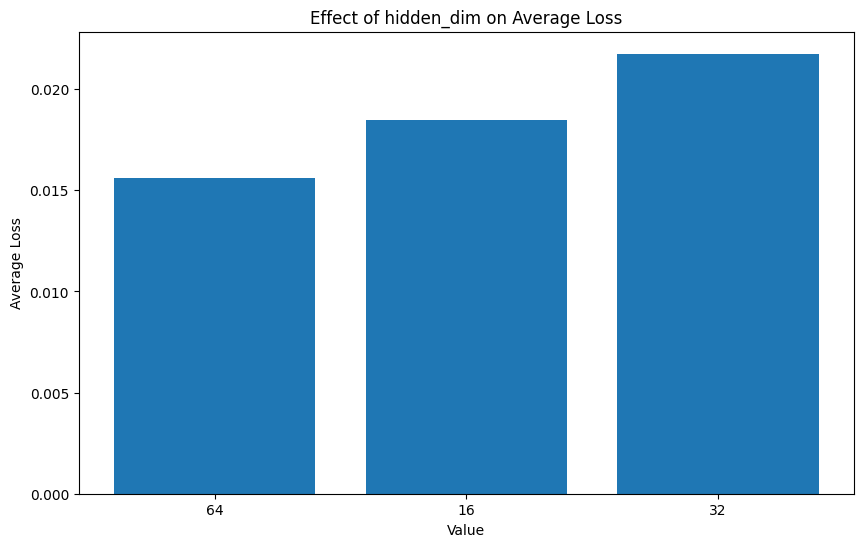

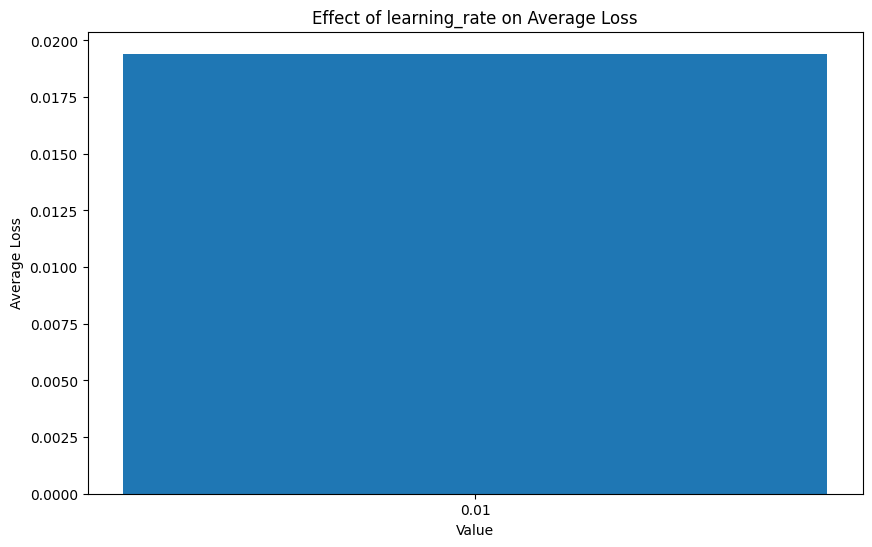

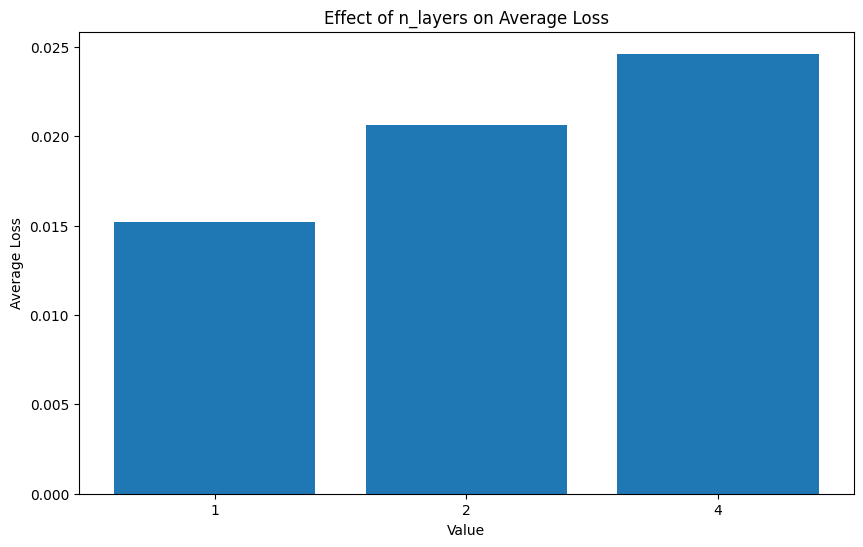

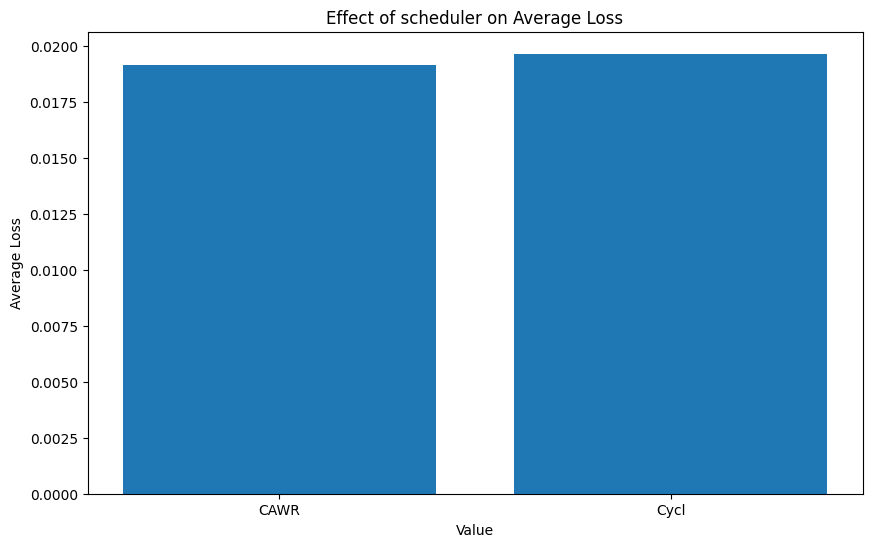

In [16]:
for hparam in hparam_effects:
    hparam_values = list(hparam_effects[hparam].keys())
    avg_losses = list(hparam_effects[hparam].values())

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(hparam_values)), avg_losses)
    plt.xticks(range(len(hparam_values)), hparam_values)
    plt.xlabel('Value')
    plt.ylabel('Average Loss')
    plt.title(f'Effect of {hparam} on Average Loss')
    plt.show()